## Code to have 2D Maxwell (with B in the direction z) using SummationByParts operators.

This is to be ported to the PIC code.

In [1]:
using Plots
using SummationByPartsOperators
using LinearAlgebra
using ArraysOfArrays

In [2]:
include("../../PIC/PIC-1D/aux_functions/aux_functions_grid.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_E-B.jl")
include("../../PIC/PIC-1D/aux_functions/aux_functions_RHS.jl")

RK4_Step!! (generic function with 1 method)

In [19]:
J = (100,100)
Box = (0.0,1.0,0.0,1.0)
dx = differentials(Box,J)
D = 2

xv = [(i-1)*dx[1] for i in 1:J[1]]
yv = [(i-1)*dx[2] for i in 1:J[2]];

In [20]:
Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[1], xmax=Box[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box[3], xmax=Box[4], N=J[2])

Periodic first-derivative operator of order 6 on a grid in [0.0, 1.0] using 100 nodes, 
stencils with 3 nodes to the left, 3 nodes to the right, and coefficients of Fornberg (1998) 
  Calculation of Weights in Finite Difference Formulas. 
  SIAM Rev. 40.3, pp. 685-691.

### Initial Data

In [47]:
#k = 2π*[3,3]
#fe(x,y) = sin(k[1]*x)*sin(k[2]*y)
function fp(x,y) 
    x0 = [0.5,0.5]
    r20 = 0.1
    r2 = (x-x0[1])^2+(y-x0[2])^2
    if r2 - r20 < 0
        return (r2 - r20)^2
    else
        return 0.0
    end
end
Ea = [((2-l)*(yv[j] - 0.5) - (l-1)*(xv[i] - 0.5))*fp(xv[i],yv[j]) for l in 1:2, i in 1:J[1], j in 1:J[2]];
B = [fp(xv[i],yv[j]) for i in 1:J[1], j in 1:J[2]];


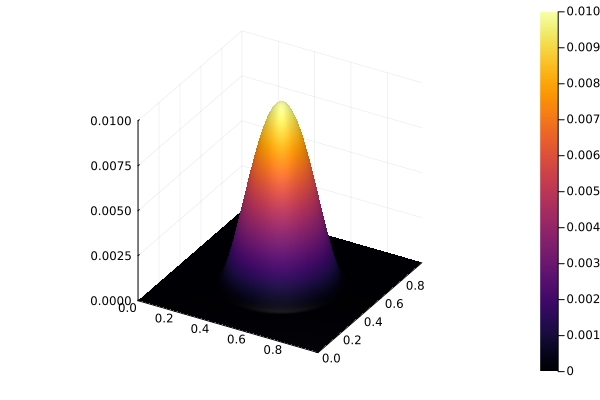

In [26]:
surface(yv,xv,B)

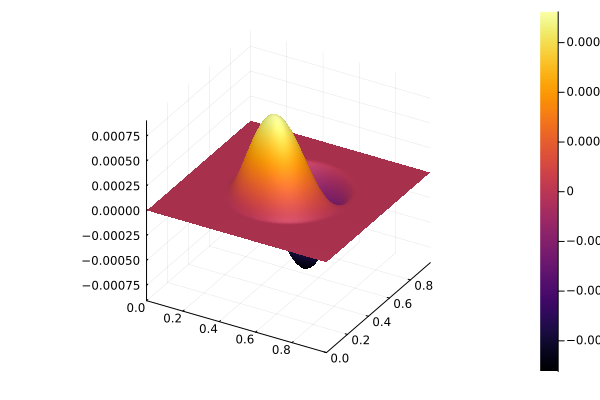

In [29]:
surface(yv,xv,Ea[2,:,:])

We upload the initial data onto the evolution vector.

In [48]:
u = Vector{Float64}(undef,3*J[1]*J[2])
du = Vector{Float64}(undef,3*J[1]*J[2])

F = reshape(u,3,J[1],J[2])

F[1:2,:,:] = Ea
F[3,:,:] = B

100×100 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 ⋮                        ⋮              ⋱            ⋮                   
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

Check that it is OK for this toy data.

In [52]:
@show F[1,30,40]
@show F[2,30,20]
@show F[3,30,20]

F[1, 30, 40] = -0.00021102839999999996
F[2, 30, 20] = 0.0
F[3, 30, 20] = 0.0


0.0

Define the vectors to put the space derivatives.

In [53]:
function F!(u, t, par)
    du = par
    u_a = reshape(u,(3,J...))
    Du_a = reshape(du,(3,J...))
    for i in 1:J[1]
        mul!(view(Du_a,1,i,:),Dy, view(u_a,3,i,:),one(eltype(u_a)))
        mul!(view(Du_a,3,i,:),Dy, view(u_a,1,i,:),-one(eltype(u_a)))
    end
    for j in 1:J[2]
        mul!(view(Du_a,2,:,j),Dx, view(u_a,3,:,j),-one(eltype(u_a)))
        mul!(view(Du_a,3,:,j),Dx, view(u_a,2,:,j),one(eltype(u_a)),one(eltype(u_a)))
    end
    return du[:]
end

F! (generic function with 1 method)

In [54]:

function get_Energy(u,J,Box)
    U_a = reshape(u,(3,J...))
    return norm(U_a)^2
end

get_Energy (generic function with 1 method)

In [55]:
(t_i, t_f) = (0.0, 1.0)
@show dt = (t_f - t_i)/ maximum(J)/4
par = du
t = t_i
get_Energy(u,J,Box)


dt = ((t_f - t_i) / maximum(J)) / 4 = 0.0025


0.063879050595615

In [56]:

for i in 1:maximum(J)*4
    RK4_Step!(F!, u, 0.0, dt, par)
    t = t + dt
    println("t = $t")
    println("Energy = $(get_Energy(u,J,Box))")
end

t = 0.0025
Energy = 0.0633048535903522
t = 0.005
Energy = 0.06283771991997245
t = 0.0075
Energy = 0.06247620634721032
t = 0.01
Energy = 0.06221931747767495
t = 0.0125
Energy = 0.06206654754979148
t = 0.015000000000000001
Energy = 0.06201797725763565
t = 0.0175
Energy = 0.06207448974468165
t = 0.02
Energy = 0.06223826275645154
t = 0.0225
Energy = 0.06251393057513394
t = 0.024999999999999998
Energy = 0.06291142581928416
t = 0.027499999999999997
Energy = 0.06345314621125889
t = 0.029999999999999995
Energy = 0.06419249420827791
t = 0.032499999999999994
Energy = 0.06526284772757772
t = 0.034999999999999996
Energy = 0.06700914832902924
t = 0.0375
Energy = 0.07034654492606773
t = 0.04
Energy = 0.07774953986967695
t = 0.0425
Energy = 0.09600746045477511
t = 0.045000000000000005
Energy = 0.14396573865149884
t = 0.04750000000000001
Energy = 0.2744325239099092
t = 0.05000000000000001
Energy = 0.6365583839003883


t = 0.05250000000000001
Energy = 1.6544247001432508
t = 0.055000000000000014
Energy = 4.540735747180679
t = 0.057500000000000016
Energy = 12.780497143555094
t = 0.06000000000000002
Energy = 36.431844589953606
t = 0.06250000000000001
Energy = 104.63327713338828
t = 0.06500000000000002
Energy = 302.08036075915663
t = 0.06750000000000002
Energy = 875.6819106288897
t = 0.07000000000000002
Energy = 2547.1405636633017
t = 0.07250000000000002
Energy = 7430.96436164041
t = 0.07500000000000002
Energy = 21735.70000487889
t = 0.07750000000000003
Energy = 63726.11257397351
t = 0.08000000000000003
Energy = 187230.06771936812
t = 0.08250000000000003
Energy = 551140.3303125412
t = 0.08500000000000003
Energy = 1.6251865490477646e6
t = 0.08750000000000004
Energy = 4.799924750197537e6
t = 0.09000000000000004
Energy = 1.4197100842982791e7
t = 0.09250000000000004
Energy = 4.2048408548080355e7


t = 0.09500000000000004
Energy = 1.2469254110154715e8
t = 0.09750000000000004
Energy = 3.701976291003486e8
t = 0.10000000000000005
Energy = 1.1002577336394486e9
t = 0.10250000000000005
Energy = 3.2733454542557526e9
t = 0.10500000000000005
Energy = 9.747605348234898e9
t = 0.10750000000000005
Energy = 2.9052765463687042e10
t = 0.11000000000000006
Energy = 8.666376831076628e10
t = 0.11250000000000006
Energy = 2.5871843425485645e11
t = 0.11500000000000006
Energy = 7.729259167906521e11
t = 0.11750000000000006
Energy = 2.310742937505723e12
t = 0.12000000000000006
Energy = 6.912778948191552e12
t = 0.12250000000000007
Energy = 2.0693132801972582e13
t = 0.12500000000000006
Energy = 6.198102642051637e13
t = 0.12750000000000006
Energy = 1.857537746969801e14
t = 0.13000000000000006
Energy = 5.569949189914763e14


t = 0.13250000000000006
Energy = 1.6710470771949445e15
t = 0.13500000000000006
Energy = 5.015796588916516e15
t = 0.13750000000000007
Energy = 1.5062446532166302e16
t = 0.14000000000000007
Energy = 4.525293007196509e16
t = 0.14250000000000007
Energy = 1.3601451298465269e17
t = 0.14500000000000007
Energy = 4.0898129912193606e17
t = 0.14750000000000008
Energy = 1.230251968305283e18
t = 0.15000000000000008
Energy = 3.7021184234644844e18
t = 0.15250000000000008
Energy = 1.1144632856084814e19
t = 0.15500000000000008
Energy = 3.3560963076013445e19
t = 0.15750000000000008
Energy = 1.010998623624431e20
t = 0.1600000000000001
Energy = 3.0465537098322824e20
t = 0.1625000000000001
Energy = 9.183413846073997e20
t = 0.1650000000000001
Energy = 2.7690557741286965e21
t = 0.1675000000000001
Energy = 8.351931443823018e21
t = 0.1700000000000001
Energy = 2.5197965820438195e22
t = 0.1725000000000001
Energy = 7.60437072210732e22


t = 0.1750000000000001
Energy = 2.2954953270728956e23
t = 0.1775000000000001
Energy = 6.931084048459246e23
t = 0.1800000000000001
Energy = 2.093312192684883e24
t = 0.1825000000000001
Energy = 6.323704366521568e24
t = 0.1850000000000001
Energy = 1.9107797062226022e25
t = 0.1875000000000001
Energy = 5.774948607129199e25
t = 0.1900000000000001
Energy = 1.7457463500783287e26
t = 0.19250000000000012
Energy = 5.278455696573973e26
t = 0.19500000000000012
Energy = 1.596329956451628e27
t = 0.19750000000000012
Energy = 4.8286522812579694e27
t = 0.20000000000000012
Energy = 1.4608789676683317e28
t = 0.20250000000000012
Energy = 4.42064081129079e28
t = 0.20500000000000013
Energy = 1.3379400626494839e29
t = 0.20750000000000013
Energy = 4.050105778539755e29
t = 0.21000000000000013
Energy = 1.2262309683718566e30
t = 0.21250000000000013
Energy = 3.713234784997974e30
t = 0.21500000000000014
Energy = 1.1246175191894958e31
t = 0.21750000000000014
Energy = 3.406651795111232e31
t = 0.22000000000000014
Ener

t = 0.22750000000000015
Energy = 2.87269574496199e33
t = 0.23000000000000015
Energy = 8.70842525822647e33
t = 0.23250000000000015
Energy = 2.640282651279689e34
t = 0.23500000000000015
Energy = 8.00609238805848e34
t = 0.23750000000000016
Energy = 2.4280006068762265e35
t = 0.24000000000000016
Energy = 7.364337542450608e35
t = 0.24250000000000016
Energy = 2.2339528950862168e36
t = 0.24500000000000016
Energy = 6.777484589016887e36
t = 0.24750000000000016
Energy = 2.0564401817447752e37
t = 0.25000000000000017
Energy = 6.24044401227944e37
t = 0.25250000000000017
Energy = 1.8939375688045493e38
t = 0.25500000000000017
Energy = 5.748645273358803e38
t = 0.2575000000000002
Energy = 1.745074641866771e39
t = 0.2600000000000002
Energy = 5.297977914812413e39
t = 0.2625000000000002
Energy = 1.608618074277861e40
t = 0.2650000000000002
Energy = 4.884740145439121e40
t = 0.2675000000000002
Energy = 1.4834564214400962e41
t = 0.2700000000000002
Energy = 4.5055938432262536e41
t = 0.2725000000000002
Energy = 

t = 0.2775000000000002
Energy = 1.263103173050306e43
t = 0.2800000000000002
Energy = 3.8378094256864447e43
t = 0.2825000000000002
Energy = 1.1661860780028012e44
t = 0.2850000000000002
Energy = 3.5439813488914197e44
t = 0.2875000000000002
Energy = 1.0770935155301824e45
t = 0.2900000000000002
Energy = 3.273807238130509e45
t = 0.2925000000000002
Energy = 9.951529348313256e45
t = 0.2950000000000002
Energy = 3.025261507981218e46
t = 0.2975000000000002
Energy = 9.197541222416424e46
t = 0.3000000000000002
Energy = 2.7965054334894856e47
t = 0.3025000000000002
Energy = 8.503428953460709e47
t = 0.3050000000000002
Energy = 2.5858683566075984e48
t = 0.3075000000000002
Energy = 7.864154995224476e48
t = 0.3100000000000002
Energy = 2.391830972101207e49
t = 0.3125000000000002
Energy = 7.275136204115996e49
t = 0.3150000000000002
Energy = 2.2130104387307354e50
t = 0.3175000000000002
Energy = 6.732199375716567e50


t = 0.32000000000000023
Energy = 2.0481470958036515e51
t = 0.32250000000000023
Energy = 6.231541545792104e51
t = 0.32500000000000023
Energy = 1.8960925944061417e52
t = 0.32750000000000024
Energy = 5.76969449374828e52
t = 0.33000000000000024
Energy = 1.7557992775758156e53
t = 0.33250000000000024
Energy = 5.343492959506445e53
t = 0.33500000000000024
Energy = 1.6263106650480478e54
t = 0.33750000000000024
Energy = 4.9500461473793215e54
t = 0.34000000000000025
Energy = 1.5067529165578553e55
t = 0.34250000000000025
Energy = 4.586712144342094e55
t = 0.34500000000000025
Energy = 1.3963271634724299e56
t = 0.34750000000000025
Energy = 4.2510749264689985e56
t = 0.35000000000000026
Energy = 1.294302612154523e57
t = 0.35250000000000026
Energy = 3.9409236673593194e57
t = 0.35500000000000026
Energy = 1.2000103342380387e58
t = 0.35750000000000026
Energy = 3.6542340970479487e58
t = 0.36000000000000026
Energy = 1.112837669206218e59
t = 0.36250000000000027
Energy = 3.3891516899721586e59
t = 0.36500000000

t = 0.36750000000000027
Energy = 3.1439764867108116e60
t = 0.3700000000000003
Energy = 9.576520583231166e60
t = 0.3725000000000003
Energy = 2.917149376984335e61
t = 0.3750000000000003
Energy = 8.886520642490826e61
t = 0.3775000000000003
Energy = 2.70723969127683e62
t = 0.3800000000000003
Energy = 8.247897281840789e62
t = 0.3825000000000003
Energy = 2.5129339658169717e63
t = 0.3850000000000003
Energy = 7.656670014134735e63
t = 0.3875000000000003
Energy = 2.3330257608733886e64
t = 0.3900000000000003
Energy = 7.109181835407858e64
t = 0.3925000000000003
Energy = 2.1664064256737457e65
t = 0.3950000000000003
Energy = 6.602071402989395e65
t = 0.3975000000000003
Energy = 2.0120567149932686e66
t = 0.4000000000000003
Energy = 6.132247769201068e66
t = 0.4025000000000003
Energy = 1.8690391727906684e67
t = 0.4050000000000003
Energy = 5.696867417897872e67
t = 0.4075000000000003
Energy = 1.7364912073796599e68


t = 0.4100000000000003
Energy = 5.293313378175289e68
t = 0.4125000000000003
Energy = 1.613618790669468e69
t = 0.4150000000000003
Energy = 4.919176213488137e69
t = 0.4175000000000003
Energy = 1.499690721122833e70
t = 0.4200000000000003
Energy = 4.572236705597251e70
t = 0.4225000000000003
Energy = 1.3940333963816854e71
t = 0.4250000000000003
Energy = 4.2504500715238293e71
t = 0.4275000000000003
Energy = 1.2960260470995988e72
t = 0.4300000000000003
Energy = 3.951931568344209e72
t = 0.43250000000000033
Energy = 1.2050963884836859e73
t = 0.43500000000000033
Energy = 3.6749433554568996e73
t = 0.43750000000000033
Energy = 1.1207166504624562e74
t = 0.44000000000000034
Energy = 3.4178824971223713e74
t = 0.44250000000000034
Energy = 1.0423999513262246e75
t = 0.44500000000000034
Energy = 3.1792699998085796e75
t = 0.44750000000000034
Energy = 9.696969831902277e75
t = 0.45000000000000034
Energy = 2.957740789340754e76
t = 0.45250000000000035
Energy = 9.021929807576927e76
t = 0.45500000000000035
Ener

t = 0.45750000000000035
Energy = 8.39504947654388e77
t = 0.46000000000000035
Energy = 2.5609872936743937e78
t = 0.46250000000000036
Energy = 7.81279117105894e78
t = 0.46500000000000036
Energy = 2.3835237530363635e79
t = 0.46750000000000036
Energy = 7.2718862596742e79
t = 0.47000000000000036
Energy = 2.218650262640775e80
t = 0.47250000000000036
Energy = 6.769313831228939e80
t = 0.47500000000000037
Energy = 2.065448343825893e81
t = 0.47750000000000037
Energy = 6.302281150710445e81
t = 0.48000000000000037
Energy = 1.9230687779154096e82
t = 0.4825000000000004
Energy = 5.868205731340336e82
t = 0.4850000000000004
Energy = 1.7907261754610187e83
t = 0.4875000000000004
Energy = 5.464698881789029e83


t = 0.4900000000000004
Energy = 1.6676939912313316e84
t = 0.4925000000000004
Energy = 5.089550600513342e84
t = 0.4950000000000004
Energy = 1.5532999463816494e85
t = 0.4975000000000004
Energy = 4.740715701006182e85
t = 0.5000000000000003
Energy = 1.4469218227800886e86
t = 0.5025000000000003
Energy = 4.416301062380853e86
t = 0.5050000000000002
Energy = 1.3479835976595211e87
t = 0.5075000000000002
Energy = 4.114553909308107e87
t = 0.5100000000000001
Energy = 1.25595188964818e88
t = 0.5125000000000001
Energy = 3.833851033990182e88
t = 0.515
Energy = 1.1703326898369384e89


t = 0.5175
Energy = 3.5726888806891204e89
t = 0.5199999999999999
Energy = 1.090668353896915e90
t = 0.5224999999999999
Energy = 3.329674420412099e90
t = 0.5249999999999998
Energy = 1.016534833392697e91


t = 0.5274999999999997
Energy = 3.1035167497708246e91
t = 0.5299999999999997
Energy = 9.475391263669077e91
t = 0.5324999999999996
Energy = 2.8930193538427956e92
t = 0.5349999999999996
Energy = 8.83316929021304e92
t = 0.5374999999999995
Energy = 2.6970729781302912e93


t = 0.5399999999999995
Energy = 8.235304719061554e93
t = 0.5424999999999994
Energy = 2.514649059492101e94
t = 0.5449999999999994
Energy = 7.678665254695277e94
t = 0.5474999999999993
Energy = 2.344793670261676e95


t = 0.5499999999999993
Energy = 7.160345611256624e95
t = 0.5524999999999992
Energy = 2.186621933706779e96
t = 0.5549999999999992
Energy = 6.677650551898631e96
t = 0.5574999999999991
Energy = 2.0393128725684166e97
t = 0.559999999999999
Energy = 6.2280792410774406e97
t = 0.562499999999999
Energy = 1.9021046556756488e98
t = 0.564999999999999
Energy = 5.809310803897341e98
t = 0.5674999999999989
Energy = 1.7742902105987103e99
t = 0.5699999999999988
Energy = 5.41919099556696e99
t = 0.5724999999999988
Energy = 1.655213173003884e100
t = 0.5749999999999987
Energy = 5.055719892177583e100
t = 0.5774999999999987
Energy = 1.5442641458345514e101
t = 0.5799999999999986
Energy = 4.7170405214450566e101
t = 0.5824999999999986
Energy = 1.4408772436866409e102
t = 0.5849999999999985
Energy = 4.4014283588329446e102


t = 0.5874999999999985
Energy = 1.3445268997933656e103
t = 0.5899999999999984
Energy = 4.107281620657422e103
t = 0.5924999999999984
Energy = 1.254724914902151e104
t = 0.5949999999999983
Energy = 3.833112291418717e104
t = 0.5974999999999983
Energy = 1.1710177290323814e105
t = 0.5999999999999982
Energy = 3.577537827759399e105
t = 0.6024999999999981
Energy = 1.0929838986609612e106
t = 0.6049999999999981
Energy = 3.3392734861609284e106
t = 0.607499999999998
Energy = 1.0202317633071162e107
t = 0.609999999999998
Energy = 3.11712522579717e107
t = 0.6124999999999979
Energy = 9.523972867904692e107
t = 0.6149999999999979
Energy = 2.909983141903414e108
t = 0.6174999999999978
Energy = 8.891420596281983e108
t = 0.6199999999999978
Energy = 2.716815388624897e109
t = 0.6224999999999977
Energy = 8.30151450127945e109
t = 0.6249999999999977
Energy = 2.536662553609632e110
t = 0.6274999999999976
Energy = 7.751328927320644e110
t = 0.6299999999999976
Energy = 2.3686324496337483e111
t = 0.6324999999999975
Ene

t = 0.6374999999999974
Energy = 6.759426101258679e112
t = 0.6399999999999973
Energy = 2.065679227532242e113
t = 0.6424999999999973
Energy = 6.312823963068333e113
t = 0.6449999999999972
Energy = 1.929266202418561e114
t = 0.6474999999999972
Energy = 5.896146376842627e114
t = 0.6499999999999971
Energy = 1.8019881200904106e115


t = 0.6524999999999971
Energy = 5.507355363505983e115
t = 0.654999999999997
Energy = 1.6832232900384587e116
t = 0.657499999999997
Energy = 5.14455438210083e116
t = 0.6599999999999969
Energy = 1.5723931320642935e117
t = 0.6624999999999969
Energy = 4.8059782967653696e117
t = 0.6649999999999968
Energy = 1.4689591212216731e118
t = 0.6674999999999968
Energy = 4.489984073641761e118
t = 0.6699999999999967
Energy = 1.3724199547628817e119
t = 0.6724999999999967
Energy = 4.1950421530408926e119
t = 0.6749999999999966
Energy = 1.2823089244843056e120
t = 0.6774999999999965
Energy = 3.919728446423829e120


t = 0.6799999999999965
Energy = 1.198191479149235e121
t = 0.6824999999999964
Energy = 3.6627169116535923e121
t = 0.6849999999999964
Energy = 1.1196629628467053e122
t = 0.6874999999999963
Energy = 3.422772663552342e122
t = 0.6899999999999963
Energy = 1.0463465162316064e123
t = 0.6924999999999962
Energy = 3.1987455800947744e123
t = 0.6949999999999962
Energy = 9.778911285910952e123
t = 0.6974999999999961
Energy = 2.9895643676020333e124
t = 0.6999999999999961
Energy = 9.139698296028459e124
t = 0.702499999999996
Energy = 2.7942310510936406e125
t = 0.704999999999996
Energy = 8.542780104982913e125
t = 0.7074999999999959
Energy = 2.6118158585274977e126
t = 0.7099999999999959
Energy = 7.985318651248605e126
t = 0.7124999999999958
Energy = 2.441452470028183e127
t = 0.7149999999999958
Energy = 7.464669421206902e127
t = 0.7174999999999957
Energy = 2.2823336053880086e128


t = 0.7199999999999956
Energy = 6.978368000784529e128
t = 0.7224999999999956
Energy = 2.133706925138806e129
t = 0.7249999999999955
Energy = 6.524117581863332e129
t = 0.7274999999999955
Energy = 1.9948712223490725e130
t = 0.7299999999999954
Energy = 6.099777353980357e130
t = 0.7324999999999954
Energy = 1.865172884013528e131
t = 0.7349999999999953
Energy = 5.7033517170382685e131
t = 0.7374999999999953
Energy = 1.7440026024820422e132
t = 0.7399999999999952
Energy = 5.3329802555452934e132
t = 0.7424999999999952
Energy = 1.6307923188327835e133
t = 0.7449999999999951
Energy = 4.986928419333299e133
t = 0.7474999999999951
Energy = 1.5250123814402737e134
t = 0.749999999999995
Energy = 4.663578859791626e134
t = 0.752499999999995
Energy = 1.4261689042315052e135
t = 0.7549999999999949
Energy = 4.361423374430199e135
t = 0.7574999999999948
Energy = 1.3338013102708015e136
t = 0.7599999999999948
Energy = 4.079055416072929e136
t = 0.7624999999999947
Energy = 1.2474800473740878e137
t = 0.764999999999994

t = 0.7674999999999946
Energy = 1.1668044634325908e138
t = 0.7699999999999946
Energy = 3.56852285496891e138
t = 0.7724999999999945
Energy = 1.0914008300311158e139
t = 0.7749999999999945
Energy = 3.3379931330769804e139
t = 0.7774999999999944
Energy = 1.0209205037826876e140
t = 0.7799999999999944
Energy = 3.122509063409677e140
t = 0.7824999999999943
Energy = 9.550382155749057e140
t = 0.7849999999999943
Energy = 2.9210771024743776e141
t = 0.7874999999999942
Energy = 8.934504786387298e141
t = 0.7899999999999942
Energy = 2.732770204032466e142
t = 0.7924999999999941
Energy = 8.358741070121178e142
t = 0.794999999999994
Energy = 2.5567232992364404e143
t = 0.797499999999994
Energy = 7.820448365831215e143
t = 0.7999999999999939
Energy = 2.3921290894749e144
t = 0.8024999999999939
Energy = 7.317160414635402e144
t = 0.8049999999999938
Energy = 2.238234129847409e145


t = 0.8074999999999938
Energy = 6.846575389685604e145
t = 0.8099999999999937
Energy = 2.0943351827864983e146
t = 0.8124999999999937
Energy = 6.406544769631779e146


t = 0.8149999999999936
Energy = 1.9597758228209816e147
t = 0.8174999999999936
Energy = 5.995062977856243e147
t = 0.8199999999999935
Energy = 1.8339432748423648e148
t = 0.8224999999999935
Energy = 5.610257733742221e148
t = 0.8249999999999934
Energy = 1.7162654695028403e149
t = 0.8274999999999934
Energy = 5.250381066096028e149
t = 0.8299999999999933
Energy = 1.606208300546674e150
t = 0.8324999999999932
Energy = 4.91380094241374e150
t = 0.8349999999999932
Energy = 1.5032730699639845e151


t = 0.8374999999999931
Energy = 4.598993470992612e151
t = 0.8399999999999931
Energy = 1.4069941078633395e152
t = 0.842499999999993
Energy = 4.304535635954505e152
t = 0.844999999999993
Energy = 1.316936554893347e153
t = 0.8474999999999929
Energy = 4.029098528091461e153
t = 0.8499999999999929
Energy = 1.2326942959090045e154
t = 0.8524999999999928
Energy = 3.771441037079228e154
t = 0.8549999999999928
Energy = 1.1538880343811323e155
t = 0.8574999999999927
Energy = 3.530403973048355e155
t = 0.8599999999999927
Energy = 1.0801634977914076e156
t = 0.8624999999999926
Energy = 3.3049045877689388e156
t = 0.8649999999999926
Energy = 1.011189764945792e157
t = 0.8674999999999925
Energy = 3.0939314678072945e157
t = 0.8699999999999924
Energy = 9.466577067793997e157
t = 0.8724999999999924
Energy = 2.896539773963092e158
t = 0.8749999999999923
Energy = 8.862785328199134e158
t = 0.8774999999999923
Energy = 2.7118468031049667e159


t = 0.8799999999999922
Energy = 8.297824360278638e159
t = 0.8824999999999922
Energy = 2.5390278502018462e160
t = 0.8849999999999921
Energy = 7.769173292436493e160
t = 0.8874999999999921
Energy = 2.3773123499057245e161
t = 0.889999999999992
Energy = 7.274476669460128e161
t = 0.892499999999992
Energy = 2.2259802784883636e162
t = 0.8949999999999919
Energy = 6.811533464674846e162
t = 0.8974999999999919
Energy = 2.0843587982775178e163
t = 0.8999999999999918
Energy = 6.378286832215917e163
t = 0.9024999999999918
Energy = 1.9518191279854716e164
t = 0.9049999999999917
Energy = 5.97281454876674e164
t = 0.9074999999999916
Energy = 1.8277736234808679e165
t = 0.9099999999999916
Energy = 5.5933200976412986e165
t = 0.9124999999999915
Energy = 1.711673054630554e166
t = 0.9149999999999915
Energy = 5.238124351367809e166
t = 0.9174999999999914
Energy = 1.6030040648374984e167
t = 0.9199999999999914
Energy = 4.905657811976209e167
t = 0.9224999999999913
Energy = 1.5012868008291917e168


t = 0.9249999999999913
Energy = 4.594453371022257e168
t = 0.9274999999999912
Energy = 1.4060727011136617e169
t = 0.9299999999999912
Energy = 4.3031395540106154e169
t = 0.9324999999999911
Energy = 1.3169424323218597e170
t = 0.9349999999999911
Energy = 4.03043421632339e170
t = 0.937499999999991
Energy = 1.2335039634003134e171
t = 0.939999999999991
Energy = 3.7751386600321956e171
t = 0.9424999999999909
Energy = 1.1553907683105305e172
t = 0.9449999999999908
Energy = 3.536132143083604e172
t = 0.9474999999999908
Energy = 1.0822601485355254e173
t = 0.9499999999999907
Energy = 3.3123667543111586e173
t = 0.9524999999999907
Energy = 1.0137916672925337e174
t = 0.9549999999999906
Energy = 3.1028626295527213e174
t = 0.9574999999999906
Energy = 9.496856879076688e174
t = 0.9599999999999905
Energy = 2.9067034858496285e175
t = 0.9624999999999905
Energy = 8.896620093260188e175


t = 0.9649999999999904
Energy = 2.723032452283098e176
t = 0.9674999999999904
Energy = 8.334585922122452e176
t = 0.9699999999999903
Energy = 2.551048177472018e177
t = 0.9724999999999903
Energy = 7.808303695446874e177
t = 0.9749999999999902
Energy = 2.390001195122596e178
t = 0.9774999999999902
Energy = 7.315481360227385e178
t = 0.9799999999999901
Energy = 2.2391905302914675e179
t = 0.98249999999999
Energy = 6.853975109950042e179
t = 0.98499999999999
Energy = 2.0979605302067635e180
t = 0.9874999999999899
Energy = 6.421779699765832e180
t = 0.9899999999999899
Energy = 1.9656979045923263e181
t = 0.9924999999999898
Energy = 6.017019401596147e181
t = 0.9949999999999898
Energy = 1.8418289614647007e182
t = 0.9974999999999897
Energy = 5.637939556337629e182
t = 0.9999999999999897
Energy = 1.7258170253261063e183


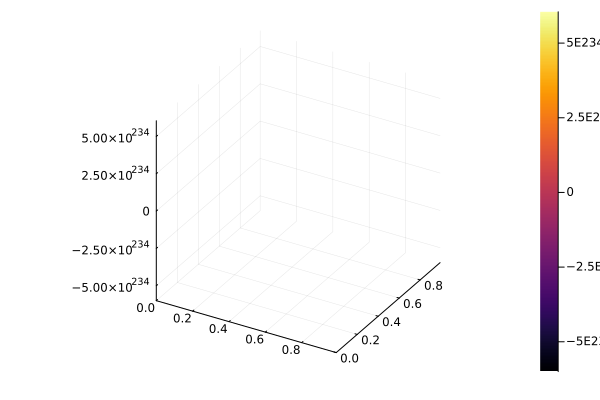

In [40]:
Ef1 = reshape(u,(3,J...))[1,:,:]

surface(yv,xv,Ef1)